# 3강 윤관선과 분할     

본 항목에서는 아래 항목들을 다룬다  
+ Otsu 알고리즘을 사용한 그레이스케일 이미지 이진화
+ 이진 이미지에서 외부 및 내부 윤곽선 찾기
+ 이진 이미지에서 연결된 구성 요소 추출  
+ 선과 원을 2차원의 점의 집합으로 맞추기  
+ 이미지 모멘트 계산  
+ 곡선으로 작업: 근사, 길이, 면적  
+ 윤곽선 내부에서 점의 포함 여부 확인  
+ 지정된 2차원 점과 모든 픽셀 간의 거리 계산  
+ k-평균 알고리즘을 이용한 이미지 분할
+ 분할 시드를 사용해 이미지 분할: 워터쉐드 알고리즘

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

### Otsu 알고리즘을 사용한 그레이 스케일 이미지 이진화  
Otsu는 이미지 히스토그램을 이용해서 이미지를 두 개의 클래스로 가장 잘 분할 할 수 있는 intensity 값을 찾는 것이다. 이 값으로 Threshold 값으로 해서 클래스 1과 클래스 2로 분류한다.  
1. 평활화한(normalized) 히스토그램을 구한다  
2. 각 픽셀별로 threshold 값을 먹일 때 최대의 분산비율이 나올 수 있도록 설정한다.(between-class variance 알고리즘)  
(책에는 내부 분산 최소라고 되어있는데, 분산 비율= ( 클래스간 분산 / 내부 분산 )^2 , 라는 수식에서 나오는 얘기다.

In [ ]:
image = cv2.imread('../data/chaewon.jpg', 0)

otsu_thr, otsu_mask = cv2.threshold(image, -1, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
                                                                             # OTSU는 Threshold 값이 자동으로 설정되기 때문에 -1(0)을 넣어준다
                                                                             # maxval도 마찬가지. 자동설정. 0을 넣으면 검은 화면만 나온다.
                                                                             # (0.6 이상은 출력 되지만 그냥 1로 설정하는게 정석인듯)
print('Estimated threshold (Otsu): ', otsu_thr)

plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.axis('off')
plt.title('original')
plt.imshow(image, cmap='gray')

plt.subplot(122)
plt.axis('off')
plt.title('Otsu threshold')
plt.imshow(otsu_mask, cmap='gray')

plt.tight_layout()
plt.show()


### 이진 이미지에서 외부 및 내부 윤곽선 찾기  

참고: https://opencv-python.readthedocs.io/en/latest/doc/18.imageContourHierarchy/imageContourHierarchy.html

In [ ]:
image = cv2.imread('../data/chaewon.jpg', 0)

image = np.zeros((480, 640), np.uint8)
cv2.circle(image, (100, 100), 50, 255, -1)
cv2.circle(image, (100, 100), 25, 0, -1)
cv2.circle(image, (200, 100), 50, 255, -1)
cv2.circle(image, (200, 100), 25, 0, -1)

#

contours, hierarchy = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) 
# 책은 3개의 인자를 반환하는데(수정된 이미지, 윤곽선 리스트, 윤곽선 계층 속성 리스트) 버전의 차이로 return이 다르다
# https://github.com/facebookresearch/maskrcnn-benchmark/issues/339
# cv2.CHAIN_APPROX_NONE = 윤곽선의 수직과 수평 부분을 각 끝점으로 축소
# cv2.CHAIN_APPROX_NON = 압축하지 않음



image_external = np.zeros(image.shape, image.dtype)
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv2.drawContours(image_external, contours, i, 255, 1)   #drawContours(image, contours, contourIdx, color, thickness=None)
        
image_internal = np.zeros(image.shape, image.dtype)
for i in range(len(contours)):
    if hierarchy[0][i][3] != -1:
        cv2.drawContours(image_internal, contours, i, 255, 1)

# hierarchy의 3번째 차원의 3번째 값이 -1 이란 것은 내부에 더이상 contours가 없다는 의미이다
# hierarchy 구조 = 다음과 이전 윤곽선의 인덱스, 첫 자식 윤곽선, 첫 부모 윤곽선
# hierarchy의 shape는 (1, x, 4)의 형태입니다. 여기서 3번째 차원의 4개의 값이 hierarchy를 표현합니다. 각 값의 의미는 (next, prev, child, parent) 입니다. RETR_LIST는 선/후 관계만을 표현하고, parent/child관계를 표현하지 않는 mode입니다.

plt.figure(figsize=(20, 7))


plt.subplot(131)
plt.axis('off')
plt.title('original')
plt.imshow(image, cmap='gray')

plt.subplot(132)
plt.axis('off')
plt.title('external')
plt.imshow(image_external, cmap='gray')

plt.subplot(133)
plt.axis('off')
plt.title('internal')
plt.imshow(image_internal, cmap='gray')


In [ ]:
img = cv2.imread('../data/chaewon.jpg', cv2.IMREAD_GRAYSCALE) # ??? 0을 넣는거랑 cv2.IMREAD_GRAYSCALE이랑 뭐가 다르지?
img = cv2.resize(img, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

connectivity = 4
num_labels, labelmap = cv2.connectedComponents(img, connectivity, cv2.CV_32S)
# 요소 번호 튜플, 요소 레이블 포함 이미지를 반환받음
# labelmap은 입력 이미지와 동일한 크기며, 각 픽셀은 해당 픽셀이 속한 요소에 따라 [0, 요소개수] 범위의 값을 가진다
display(labelmap)

img = np.hstack((img, labelmap.astype(np.float32)/(num_labels-1)))
cv2.imshow('Connected components', img)
cv2.waitKey()
cv2.destroyAllWindows()

img = cvimg = cv2.imread('../data/chaewon.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
otsu_thr, otsu_mask = cv2.threshold(img, -1, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# otsu_mask = cv2.adaptiveThreshold(img, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 10)


output = cv2.connectedComponentsWithStats(otsu_mask, connectivity, cv2.CV_32S)

num_labels, labelmap, stats, centers = output       # stats 가 status가 아니라 statistics이다
# https://stackoverflow.com/questions/35854197/how-to-use-opencvs-connected-components-with-stats-in-python
# labelmap: 입력 이미지의 크기 행렬이다. 각각의 값은 label의 값과 같다. (무슨 말이지...?)
# stats: 라벨의 개수만큼의 길이를 가지고(행), stat의 정보를 가진다. stat의 정보는 다음과 같다
#       stat[0]=cv2.CC_STAT_LEFT The leftmost (x) coordinate which is the inclusive start of the bounding box in the horizontal direction.
#       stat[1]=cv2.CC_STAT_TOP The topmost (y) coordinate which is the inclusive start of the bounding box in the vertical direction.
#       stat[2]=cv2.CC_STAT_WIDTH The horizontal size of the bounding box
#       stat[3]=cv2.CC_STAT_HEIGHT The vertical size of the bounding box
#       stat[4]=cv2.CC_STAT_AREA The total area (in pixels) of the connected component

 
# Statistics output for each label, including the background label, see below for available statistics. Statistics are accessed via stats[label, COLUMN] where available columns are defined below.
#
# It has a length equal to the number of labels and a width equal to the number of stats. It can be used with the OpenCV documentation for it:
# Labels is a matrix the size of the input image where each element has a value equal to its label.
# centers: label의 x, y좌표의 중간값을 반환한다.


colored = np.full((img.shape[0], img.shape[1], 3), 0, np.uint8)

print(labelmap.shape)
print(colored.shape)

for l in range(1, num_labels):
    if stats[l][4] > 50:                                        # 각각의 label에 접근해서 CC_STAT_AREA가 50 이상인것만 고른다
        colored[labelmap == l] = (0, 255*l/num_labels,255*num_labels/l)                     # labelmap == l 은 boolean list를 반환한다.
                                                                                            # 즉 list[list == k] 는 인덱싱이다!
        cv2.circle(colored, (int(centers[l][0]), int(centers[l][1])), 5, (255, 0, 0), -1)
        img = cv2.cvtColor(otsu_mask*255, cv2.COLOR_GRAY2BGR)

cv2.imshow('Connected components', np.hstack((img, colored)))
cv2.waitKey()
cv2.destroyAllWindows()


### 선과 원을 2차원의 점의 집합으로 맞추기  
openCV는 fitLine, fitEllipse 함수를 통해 랜덤한 점의 위치들을 근사한 타원과 직선을 반환한다  
fitEllipse는 최소 5개의 점이 필요하고, fitLine은 최소 2개의 점이 필요하다
  
fitEllipse는 2차원 점의 집합을 인수로 받아, 중심점, 반축의 길이(장반경?), 회전 각도를 반환한다.  
반환된 매개변수를 cv2.ellipse의 인자로 넣어 결과를 표시할 수 있다.  

fitline은 임의의 점의 집합을 받고, 최소화를 위한 거리 함수의 유형과, 거리함수를 제어할 값, (x0, y0) 점과 (vx, vy)의 직선 계수에 대한 허용 정확도를 매개변수로 받는다. (x0, y0)는 직선이 통과하는 지점을 결정한다.  
반환값은 (x0, y0, vx, vy)이다.  
3차원에서도 동작하고 매우 안정적이기 때문에 자주 쓰인다.

In [ ]:
img = np.full((512, 512, 3), 255, np.uint8)

ellipse_axes = (int(256*random.uniform(0, 1)), int(256*random.uniform(0,1))) # random.uniform(x, y) x와 y사이의 랜덤한 실수를 반환한다.
ellipse_angle = int(180*random.uniform(0, 1))
ellipse_ceter = (256, 256)

pts = cv2.ellipse2Poly(ellipse_ceter, ellipse_axes, ellipse_angle, 0, 360, 1)   # 타원 모양의 연속하는 점의 행렬을 반환한다.
pts += np.random.uniform(-10, 10, pts.shape).astype(np.int32)                   # 각각의 점에 -10에서 10 사이의 난수를 더해준다.
                                                                                # <포인트!!> uniform의 3번쨰 인자(size) 에 pts.shape을 넣어서
                                                                                # 모든 값에 한번에 난수가 더해짐!

cv2.ellipse(img, ellipse_ceter, ellipse_axes, ellipse_angle, 0, 360, (0, 255, 0), 3)

for pt in pts:
    cv2.circle(img, (int(pt[0]), int(pt[1])), 3, (0, 0, 255))

cv2.imshow('Fit ellipse', img)
cv2.waitKey()
cv2.destroyAllWindows()

ellipse = cv2.fitEllipse(pts)
cv2.ellipse(img, ellipse, (0, 0, 0), 3)
cv2.imshow('Fit ellipse', img)
cv2.waitKey()
cv2.destroyAllWindows()

img = np.full((512, 512, 3), 255, np.uint8)

pts = np.arange(512).reshape(-1, 1)
pts = np.hstack((pts, pts))     # np.hstack(x, y): x의 오른쪽 열에 y를 추가한다
pts += np.random.uniform(-10, 10, pts.shape).astype(np.int32)

cv2.line(img, (0,0), (512, 512), (0, 255, 0), 3)

for pt in pts:
    cv2.circle(img, (int(pt[0]), int(pt[1])), 3, (0,0,255))

cv2.imshow('Fit line', img)
cv2.waitKey()
cv2.destroyAllWindows()

vx, vy, x, y = cv2.fitLine(pts, cv2.DIST_L2, 0, 0.01, 0.01)
y0 = int(y - x*vy/vx)
y1 = int((512 - x)*vy/vx + y)
cv2.line(img, (0, y0), (512, y1), (0, 0, 0), 3)

cv2.imshow('Fit line', img)
cv2.waitKey()
cv2.destroyAllWindows()

### 이미지 모멘트 계산  
# 이미지 모멘트 계산  
생략

### 곡선으로 작어비 근사, 길이, 면적  
+ 곡선의 길이와 면적 계산  
+ 볼록 외피(?)를 얻는다  
+ 곡선의 볼록 여부를 확인한다  
+ 이번 절에서 다루는 모든 작업은 윤곽선 처리 기반 알고리즘 개발에 유용하다  
+ 거짓 윤곽선을 배제하는 휴리스틱한 필터를 만들 수도 있다  

참고: https://m.blog.naver.com/samsjang/220516697251  
  
findcontours 설명. images는 버전에 따라 있거나 없음.
images, contours, hierachy = cv2.findContours(image, mode, method)  

image: 흑백이미지 또는 이진화된 이미지  
mode : 컨투어를 찾는 방법  
+ cv2.RETR_EXTERNAL: 컨투어 라인 중 가장 바깥쪽의 라인만 찾음  
cv2.RETR_LIST: 모든 컨투어 라인을 찾지만, 상하구조(hierachy)관계를 구성하지 않음  
cv2.RETR_CCOMP: 모든 컨투어 라인을 찾고, 상하구조는 2 단계로 구성함  
cv2.RETR_TREE: 모든 컨투어 라인을 찾고, 모든 상하구조를 구성함  

method : 컨투어를 찾을 때 사용하는 근사화 방법  
+ cv2.CHAIN_APPROX_NONE: 모든 컨투어 포인트를 반환  
cv2.CHAIN_APPROX_SIMPLE: 컨투어 라인을 그릴 수 있는 포인트만 반환  
cv2.CHAIN_APPROX_TC89_L1: Teh_Chin 연결 근사 알고리즘 L1 버전을 적용하여 컨투어 포인트를 줄임  
cv2.CHAIN_APPROX_TC89_KCOS: Teh_Chin 연결 근사 알고리즘 KCOS 버전을 적용하여 컨투어 포인트를 줄임  
  
drawContours 설명  
cv2.drawContours(img, contours, -1, (0, 255, 0), 3)  
img: contour를 나타낼 대상 이미지  
contours: img에 그릴 contour. 이 값은 cv2.findcontours() 함수의 2번째 리턴 값으로 리스트형 자료임. i번째 contour의 첫 번째 픽셀 좌표는 contours[i][0]과 같이 접근 가능  
-1: img에 실제로 그릴 contour 인덱스 파라미터 이값이 음수이면 모든 contour를 그림  
(0,255,0), 2: 색상과 두께


In [ ]:
img = cv2.imread('../data/minguri.jpg', cv2.IMREAD_GRAYSCALE)

# img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C ,cv2.THRESH_BINARY, 3, 3)
thr, img = cv2.threshold(img, 100, 1, cv2.THRESH_BINARY_INV)

img = np.full((512, 512, 1), 0, np.uint8)
cv2.circle(img, (256, 256), 100, 255, -1)
cv2.ellipse(img, (256, 256), (20, 200), 45, 0, 360, 255, -1)
cv2.ellipse(img, (256, 256), (20, 200), -45, 0, 360, 255, -1)

contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours: 외곽선 좌표를 가지는 2차원 리스트
# hierarchy: 상하관계정보를 가지는 리스트
#    [Next, Previous, First Child, Parent]
#    Next: 동일 레벨의 다음 contour 인덱스, 동일레벨의 다음 contour가 없으면 -1
#    Previous: 동일 레벨의 이전 contour 인덱스, 동일레벨의 이전 contour가 없으면 -1
#    First Child: 최초의 자식 contour 인덱스. 자식 contour가 없으면 -1
#    Parent: 부모 contour 인덱스. 부모 contour가 없으면 -1

color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

cv2.drawContours(color, contours, -1, (0, 255, 0), 3)
cv2.imshow('contours', color)
cv2.waitKey()
cv2.destroyAllWindows()

contour = contours[0]   # contour array가 list로 감싸져 있어서 한번 꺼낸다
print('Area of contour is %.2f' % cv2.contourArea(contour, True))   # contour의 면적 계산. 
print('Signed area of contour is %.2f' % cv2.contourArea(contour, True))
print('Signed area of contour is %.2f' % cv2.contourArea(contour[::-1], True))  # ([::-1], 순서를 역순으로 가져온다는 인덱싱), 시계 / 반시계로 넓이의 부호가 바뀜

print('Length of closed contour is %.2f' % cv2.arcLength(contour, True))    # 윤곽선의 첫 번째 점과 마지막 점을 연결한 것으로 간주 -> 닫힌 상태로 길이 계산
print('Length of open contour is %.2f' % cv2.arcLength(contour, False))     # 윤곽선의 첫 번째 점과 마지막 점을 연결했다고 간주하지 않아, 두 점 사이의 길이는 계산되지 않음

hull = cv2.convexHull(contour)  #convex: 볼록한, hull: (콩 등의)깍지를 벗기다. -> convexHull: 임의의 집합 x에 대한 가장 작은 볼록 껍질, 외피
cv2.drawContours(color, [hull], -1, (255,0,255), 3)     # 외피 그리기

cv2.imshow('contours', color)
cv2.waitKey()
cv2.destroyAllWindows()

print('Convex status of contour is %s' %cv2.isContourConvex(contour))   # contour가 볼록 껍질인가?
print('Convex status of its hull is %s' %cv2.isContourConvex(hull))     # hull이 볼록 껍질인가?

cv2.namedWindow('contours')

img = np.copy(color)

def trackbar_callback(value):
    global img
    epsillon = value*cv2.arcLength(contour, True)*0.1/255
    approx = cv2.approxPolyDP(contour, epsillon, True)      # Ramer-Douglas-Peucker 알고리즘을 구현해, 더 적은 수의 점들과 약간의 공차로 윤곽선을 찾고
                                                            # 인수로 윤곽선(근삿값), 공차(원본과 근사 윤곽선 사이의 최대거리), boolean flag(근사 된 윤곽선의 개폐여부)
    img = np.copy(color)
    cv2.drawContours(img, [approx], -1, (255, 0, 255), 3)

cv2.createTrackbar('Epsilon', 'contours', 1, 255, lambda v: trackbar_callback(v))
while True:
    cv2.imshow('contours', img)
    key = cv2.waitKey(3)
    if key == 27:
        break
cv2.destroyAllWindows()



저장이 안돼서 앞 내용은 추후 추가

### 책에 없는 watershed 코드  
출처: https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html  


(312, 252)
(312, 252)


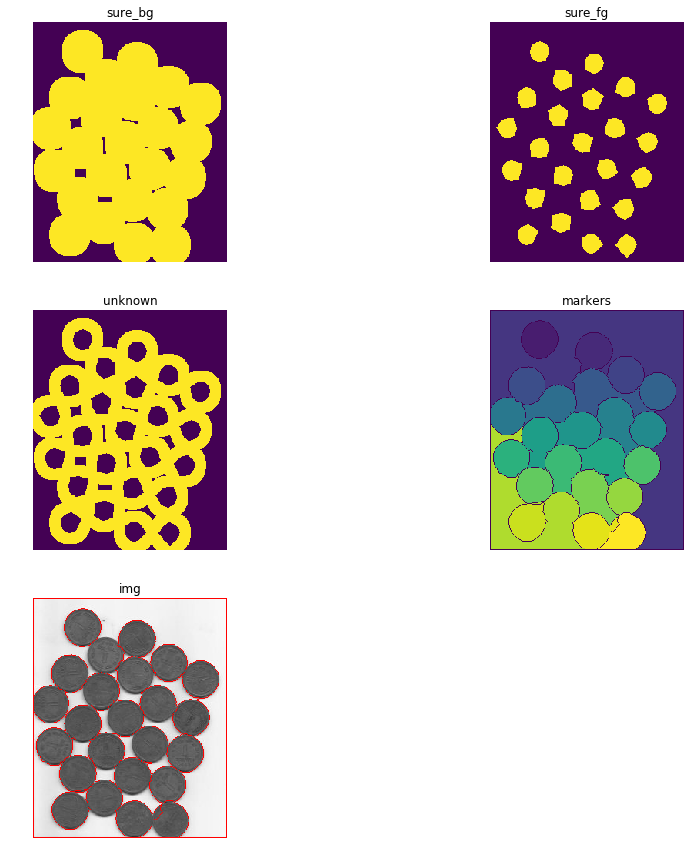

In [17]:
img = cv2.imread('../data/coins.jpg', 0)
binary, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.5*dist_transform.max(), 255,0)
sure_fg = np.uint8(sure_fg)

unknown = cv2.subtract(sure_bg, sure_fg)

plt.figure(figsize=(15, 15))
plt.subplot(321)
plt.axis('off')
plt.title('sure_bg')
plt.imshow(sure_bg)

plt.subplot(322)
plt.axis('off')
plt.title('sure_fg')
plt.imshow(sure_fg)

plt.subplot(323)
plt.axis('off')
plt.title('unknown')
plt.imshow(unknown)

ret, markers = cv2.connectedComponents(sure_fg)
#markers = markers + 1
markers[unknown == 255] = 0

print(img.shape)
print(markers.shape)

img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

markers = cv2.watershed(img, markers)
img[markers < 0] = [255,0,0]

plt.subplot(324)
plt.axis('off')
plt.title('markers')
plt.imshow(markers)

plt.subplot(325)
plt.axis('off')
plt.title('img')
plt.imshow(img)



